<a href="https://colab.research.google.com/github/ian-byrne/MADSmilestone2/blob/main/Supervised_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning: Clock Drawing Image Classification with Convolutional Neural Networks
### Stacey Beck and Ian Byrne

- Split data into sets of Training (x = image arrays ; y = labels), Test (~10% image arrays), and Validation (~10% of the Training). 
- Build CNN using Pytorch for Training and Test:
  - Specify CUDA
  - 2D convolution, Normalization (for faster training), Non-linear Activation Function (ex. RELU), Max Pooling (downsampling to reduce learned parameters).
  - Define Layers 
  - Build Forward and backward pass
  - Define optimizer (due to many - deep - nodes) ex) ADAM
  - Calculate Loss (BCE)
  - Calculate Accuracy, Precision, Recall (Confusion Matrix)
  - Plot ROC and print Confusion Matrix



In [1]:
# Clone the entire repo.
!git clone -l -s https://github.com/ian-byrne/MADSmilestone2.git

# Change directory into cloned repo
%cd MADSmilestone2

# List repo contents
#!ls

Cloning into 'MADSmilestone2'...
remote: Enumerating objects: 382, done.
remote: Counting objects: 100% (382/382), done.
remote: Compressing objects: 100% (316/316), done.
remote: Total 382 (delta 210), reused 143 (delta 60), pack-reused 0
Receiving objects: 100% (382/382), 3.02 MiB | 4.81 MiB/s, done.
Resolving deltas: 100% (210/210), done.
/content/MADSmilestone2


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import requests
from PIL import Image
import ast
import Images
from tqdm import tqdm

In [43]:
#!rm -rf /content/MADSmilestone2

In [44]:
# Read round, id, label dictionary file

cust_file = open("Data/customLabelDict.txt", "r")
#print(cust_file.readline())
contents = cust_file.read()
dictionary = ast.literal_eval(contents)
cust_file.close()

In [45]:
def get_images_test(id_rounds):
    counter = 0
    store_images = []
    #image_data = []
    label_arr = []

    for id, array in tqdm(id_rounds.items()):
        for value in array:
            if counter < 40:
                url = 'https://clockimages.s3.us-west-1.amazonaws.com/NHATS_R' + str(
                    id) + '_ClockDrawings/' + value[0] + '.tif'
                #url = 'https://test-bucket-clockids-aicrowd.s3.us-west-1.amazonaws.com/1_'+ value[0] + '.tif'
                # Open files and convert to work with Image in PIL
                response = requests.get(url)  # , stream = True)
                f = io.BytesIO(response.content)
                im_pil = Image.open(f)

                # Resize pil image files
                #resized = im_pil.resize((im_pil.width // 9, im_pil.height // 9))
                resized = im_pil.resize((284,368))
                imarray1 = np.array(resized)
                
                imarray1 = np.array(imarray1).astype(int)
                #imarray = np.logical_not(np.array(im)).astype(int) #bool to int, inverts values
                #image_data.append(get_coordinates(imarray1))  # , imarray1.shape[0], imarray1.shape[1]))

                #Store the np array images into a list
                store_images.append(imarray1)

                #print("round: ", id)

                #Visualize the resized images
                #viz_image(imarray1, resized, value[0], value[1])
                
                # Store corresponding labels
                label_arr.append(value[1])
                
                counter += 1

    return store_images, label_arr




def viz_image(image, resized, value0, value1):
  print("shape: ", image.shape)
  print("spid: ", value0)
  print("label: ", value1)

  # revert
  im2 = Image.fromarray(image)
  plt.imshow(im2)
  plt.show()

In [46]:
x, y = get_images_test(dictionary)

100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


In [47]:
X = np.array(x)
# Need to add that extra dimension for grayscale depth of 1 channel
X = np.expand_dims(X, 1)
X.shape





(40, 1, 368, 284)

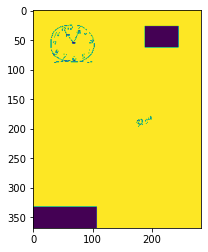

In [27]:
plt.imshow(X[0])

# Build CNN Model using Pytorch


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Building and Training
Architecture choices influenced from: 

https://www.analyticsvidhya.com/blog/2018/12/guide-convolutional-neural-network-cnn/

https://medium.datadriveninvestor.com/five-powerful-cnn-architectures-b939c9ddd57b

https://towardsdatascience.com/how-does-sparse-convolution-work-3257a0a8fd1

In [39]:
# Define some of the hyperparameters
#num_epochs = 100
batch_size = 4
learning_rate = .001
kernel_size = 3
stride = 1
padding = 1 #2*floor(3/2)
#activation function

#Get Data
# double split to get validation and test
ratio_val = 0.1
ratio_test = 0.1

# Get Train and Test split
X_split, X_test, y_split, y_test = train_test_split(X, y, test_size = ratio_test, random_state = 6) 

# Adjust remaining ratio for even split
ratio_remaining = 1 - ratio_test #.11111
ratio_val_ad = ratio_val / ratio_remaining 

# Get Train and Val split
X_train, X_val, y_train, y_val = train_test_split(X_split, y_split, test_size = ratio_val_ad, random_state = 6)

# No need to normalize

# Zip image data and labels together
training_data = [(x, y) for x, y in zip(X_train, y_train)]
validation_data = [(x,y) for x, y in zip(X_val, y_val)]
test_data = [(x,y) for x, y in zip(X_test, y_test)]


# Variables for X - X_train, X_val, X_test
#Variables for y - y_train, y_val, y_test

train_loader = torch.utils.data.DataLoader(training_data, batch_size = batch_size, shuffle = True) 
validate_loader = torch.utils.data.DataLoader(validation_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True)

#Labels 
classes = (0, 1, 2)



torch.LongTensor
torch.Size([4, 1, 368, 284])


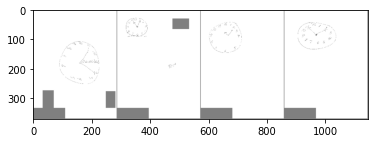

Labels:
    2     0     2     2


In [48]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
#print(images.size())
print(images.type())
#images = images.unsqueeze(1)
print(images.size())
# show images
imshow(torchvision.utils.make_grid(images, nrow = 4))
# print labels
print('Labels:')
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

#Printing as RGB, just using basic pytorch dataloader likely converting to rbg

(16, 1, 3, 3)

(16,)

(16,)

(16,)

(32, 16, 3, 3)

(32,)

(32,)

(32,)

(120, 209024)

(120,)

(30, 120)

(30,)

(3, 30)

(3,)

[1 1] loss 0.0010
Accuracy = 75.0
[2 1] loss 0.0011
Accuracy = 75.0


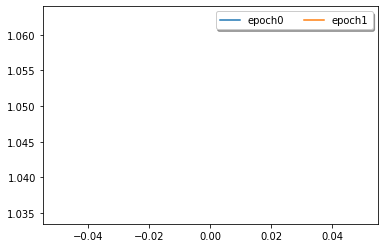

In [56]:
from torch.nn.modules.activation import ReLU
# Set to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    # without considering batch size: Input shape : (None,368, 284, 1) , parameters: (3*3*1*16+16) = 160
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, # one input channel gray scale, 16 filters out
                            kernel_size = 3, stride = 1, padding = 1) #Out:(None,368, 284, 16)

    #Normalize each output to help w/ faster learning                       
    self.bn1 = nn.BatchNorm2d(16)
    self.pool1 = nn.MaxPool2d(2, 2) #Out: (None, 184, 142, 16)
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, 
                          kernel_size = 3, stride = 1, padding = 1) #Out: (None, 184, 142, 32), params: (3*3*16*32+32) = 4640                         
    self.bn2 = nn.BatchNorm2d(32) 
    self.pool2 = nn.MaxPool2d(2, 2) #Output shape = (None, 92, 71, 32)
    # Flatten
    self.fc1 = nn.Linear(32*92*71,120)
    self.fc2 = nn.Linear(120, 30)
    self.fc3 = nn.Linear(30, 3) # left with 3 for the three classes


  def forward(self, x):
    x = self.pool1(self.bn1(F.relu(self.conv1(x))))
    x = self.pool2(self.bn2(F.relu(self.conv2(x))))
    x = x.view(-1,32*92*71)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x


# Create model object 
model = ConvNet().to(device)
for param in model.parameters():
  print(str(param.data.numpy().shape)+'\n')

# Loss function
criterion = nn.CrossEntropyLoss()

#Optimizer (can use SGD or ADAM)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #or ADAM/ momentum
acc = 0 # accuracy
epoch = 0 # training episodes
n_total_steps = len(train_loader) 

def train_model(epochs):
  # set model in training mode (recommended)
  model.train()
  for epoch in range(epochs):
    losses = []
    closs = 0
    num_times = 0
    for i, (images, labels) in enumerate(train_loader, 0):
      images = images.float().to(device) # for GPU support
      label = labels.float().to(device)

      # Forward pass through NN
      outputs = model(images)
      loss = criterion(outputs, labels)

      closs+= loss.item()

      # Backward pass, updating weights
      optimizer.zero_grad() # sets gradients to 0 to prevent interference with previous epoch
      loss.backward()
      optimizer.step()

      # Track every 100th loss:
      if i % 100 == 0:
        losses.append(loss.item())
        num_times = num_times + 1


      # print every 1000th time
      if i % 1000 == 0:
        print('[%d %d] loss %.4f'% (epoch + 1, i + 1, closs/1000))
        closs = 0
    # Calculate the accuract and save the model state  
    accuracy()

    # Plot the loss
    plt.plot(losses, label = 'epoch' + str(epoch))
    plt.legend(loc = 1, mode = 'expanded', shadow = True, ncol = 2)
  plt.show()

def accuracy():
  # set the model to evaluation mode
  model.eval()
  # Calculate performance
  correct = 0
  total = 0
  accuracy = 0
  for batches in test_loader:
    images, labels = batches
    prediction = model(images.float())
    _,prediction = torch.max(prediction.data, 1)# returns max val and index
    total += labels.size(0)
    correct +=(prediction == labels).sum().item()

    accuracy = (correct/total) * 100
  print('Accuracy = '+str(accuracy))


if __name__ == '__main__':
  train_model(2)













#Build CNN when not using pytorch's DataLoader class

In [110]:
# Create classes for training data, test data 
# So far using one batch

class Helper():
  
  def __init__(self):
    self.i = 0

    # create batches  
    #self.train_batch = [#split X_train into batches]
    #self.val_batch = [#validation batch]
    #self.test_batch = [#test batch]

    self.training_images = None
    self.training_labels = None

    self.val_images = None
    self.val_labels = None

    self.test_images = None
    self.test_labels = None
  

  def get_images(self):

    print("set up images for training, val, test")

    self.training_images = np.array(self.training_images)
    train_len = len(self.training_images)

    self.val_images = np.array(self.val_images)
    val_len = len(self.val_images)

    self.test_images = np.array(self.test_images)
    test_len = len(self.test_images)



  def next_batch(self, batch_size):
    x = self.training_images[self.i:self.i+batch_size].reshape(batch_size,368, 284) #resize to length of batch
    y = self.training_labels[self.i:self.i+batch_size]
    self.i = (self.i + batch_size) % len(self.training_images)
    return x , y 
